In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import nengo_dft
import cedar_modules

In [2]:
class AbsSigmoid(nengo.neurons.NeuronType):
    def __init__(self, initial_state=None):
        super().__init__(initial_state)

    def step(self, dt, J, output):
        output[...] = 0.5 * (1 + (J) / (1 + np.abs(J)))

In [3]:
import nengo_ocl
from nengo_ocl.utils import as_ascii
from mako.template import Template   
from nengo_ocl.clra_nonlinearities import _plan_template

def plan_abs_sigmoid(queue, J, outR, **kwargs):
    inputs = dict(J=J)
    outputs = dict(outR=outR)
    parameters = dict()
    textconf = dict(type=J.ctype)

    decs = """
        """
    text = """
        outR = 0.5*(1+J/(1+fabs(J)));
        """
    decs = as_ascii(Template(decs, output_encoding='ascii').render(**textconf))
    text = as_ascii(Template(text, output_encoding='ascii').render(**textconf))
    cl_name = "cl_abs_sigmoid"
    return _plan_template(
        queue, cl_name, text, declares=decs,
        inputs=inputs, outputs=outputs, parameters=parameters, **kwargs)

class OpenCLSimulator(nengo_ocl.Simulator):
    def _plan_AbsSigmoid(self, ops):
        J = self.all_data[[self.sidx[op.J] for op in ops]]
        R = self.all_data[[self.sidx[op.output] for op in ops]]
        return [plan_abs_sigmoid(self.queue, J, R)]


In [13]:
dt = 0.02
step_size = 0.02

model = nengo.Network()
with model:
    gauss_input = cedar_modules.GaussInput(sizes=[100], centers=[24], a=1, sigmas=[3], normalize=False).make_node()
    gauss_input_2 = cedar_modules.GaussInput(sizes=[80], centers=[31], a=1, sigmas=[12], normalize=False).make_node()
    
    neural_field = nengo_dft.DFT(shape=[100], h=-1, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field.add_single_kernel(amplitude=1, sigma=3.0, limit=5)

    neural_field_2 = nengo_dft.DFT(shape=[50, 40], h=-5, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field_2.add_single_kernel(amplitude=1, sigma=3, limit=5)    
    
    neural_field_3 = nengo_dft.DFT(shape=[80], h=-1, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field_3.add_single_kernel(amplitude=1, sigma=3, limit=5)
    
    
    convolution = cedar_modules.Convolution(input_shape=[100], amplitude=1, sigma=3, limit=5)
    convolution_2 = cedar_modules.Convolution(input_shape=[80], amplitude=1, sigma=3, limit=5)
    
    projection = cedar_modules.Projection([50, 40], [100], dimension_mapping={0:0}).make_net()
    projection_2 = cedar_modules.Projection([50, 40], [80], dimension_mapping={0:1}).make_net()
    

    nengo.Connection(gauss_input, neural_field.s, synapse=None)
    nengo.Connection(gauss_input_2, neural_field_3.s, synapse=None) 
    
    nengo.Connection(neural_field.g.neurons, convolution.input, synapse=None)
    nengo.Connection(neural_field_3.g.neurons, convolution_2.input, synapse=None)
    
    nengo.Connection(convolution.output, projection.input, synapse=None)
    nengo.Connection(convolution_2.output, projection_2.input, synapse=None)
    
    nengo.Connection(projection.output, neural_field_2.s, synapse=None)
    nengo.Connection(projection_2.output, neural_field_2.s, synapse=None)
    
    boost = nengo.Node(4.4)
    nengo.Connection(boost, neural_field_2.s, synapse=None, transform=np.ones((neural_field_2.s.size_in, 1)))
    
    p_dnf = nengo.Probe(neural_field.g.neurons)
    p_dnf_2 = nengo.Probe(neural_field_2.g.neurons)
    p_dnf_3 = nengo.Probe(neural_field_3.g.neurons)
        
sim = OpenCLSimulator(model, dt=dt)
#sim = nengo.Simulator(model, dt=dt)
with sim:
    sim.run(30)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

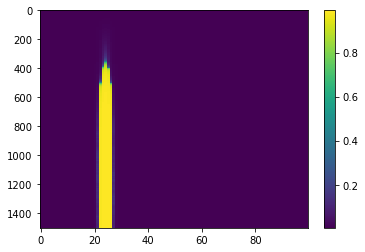

In [14]:
plt.imshow(sim.data[p_dnf], aspect='auto', interpolation='nearest')
plt.colorbar()

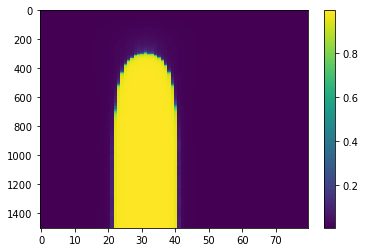

In [15]:
plt.imshow(sim.data[p_dnf_3], aspect='auto', interpolation='nearest')
plt.colorbar()

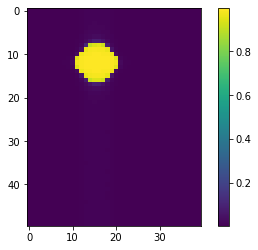

In [16]:
plt.imshow(sim.data[p_dnf_2][-1].reshape(50,40))
plt.colorbar()

In [15]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

In [ ]:
dt = 0.02
step_size = 0.02

model = nengo.Network()
with model:
    gauss_input = cedar_modules.GaussInput(sizes=[100], centers=[24], a=1, sigmas=[3])
    gauss_input_2 = cedar_modules.GaussInput(sizes=[80], centers=[31], a=1, sigmas=[12])
    
    neural_field = nengo_dft.DFT(shape=[100], h=-1, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field.add_single_kernel(amplitude=1, sigma=3.0, limit=5)

    neural_field_2 = nengo_dft.DFT(shape=[50, 40], h=-5, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field_2.add_single_kernel(amplitude=1, sigma=3, limit=5)    
    
    neural_field_3 = nengo_dft.DFT(shape=[80], h=-1, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field_3.add_single_kernel(amplitude=1, sigma=3, limit=5)
    
    
    nengo_dft.Connection(neural_field, neural_field_2[0], kernel=dict(amplitude=1,sigma=3,limit=5))
    nengo_dft.Connection(neural_field_2, neural_field_2[1], kernel=dict(amplitude=1,sigma=3,limit=5))
        
    boost = nengo.Node(4.4)
    nengo_dft.Connection(boost, neural_field)
    
    p_dnf = nengo.Probe(neural_field.g.neurons)
    p_dnf_2 = nengo.Probe(neural_field_2.g.neurons)
    p_dnf_3 = nengo.Probe(neural_field_3.g.neurons)
        
#sim = OpenCLSimulator(model, dt=dt)
sim = nengo.Simulator(model, dt=dt)
with sim:
    sim.run(30)